In [1]:
import os
os.chdir('/home/fan_qi/fan_qi/DNAm/DNAm')
import argparse
import pandas as pd
from pandas.core.frame import DataFrame
import logging
import os
import sys
import time
import numpy as np
import pandas as pd
import scanpy as sc
import torch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from scipy.spatial import distance_matrix, minkowski_distance, distance
import random
seed = 42
torch.manual_seed(seed)
#np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
#from transformers import *
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark=False

In [3]:
    parser = argparse.ArgumentParser()
    # data 
    parser.add_argument('--bulk_data', type=str, default='data/hg_beta.csv',help='Path of the bulk RNA-Seq expression profile')
    parser.add_argument('--label', type=str, default='data/hg_sample_meta.csv',help='Path of the processed bulk RNA-Seq drug screening annotation')
    parser.add_argument('--sc_data', type=str, default="scDNAm",help='Accession id for testing data, only support pre-built data.')
    #parser.add_argument('--drug', type=str, default='I.BET.762',help='Name of the selected drug, should be a column name in the input file of --label')
    parser.add_argument('--missing_value', type=int, default=1,help='The value filled in the missing entry in the drug screening annotation, default: 1')
    parser.add_argument('--test_size', type=float, default=0.2,help='Size of the test set for the bulk model traning, default: 0.2')
    parser.add_argument('--valid_size', type=float, default=0.2,help='Size of the validation set for the bulk model traning, default: 0.2')
    parser.add_argument('--var_genes_disp', type=float, default=0,help='Dispersion of highly variable genes selection when pre-processing the data. \
                         If None, all genes will be selected .default: None')
    parser.add_argument('--min_n_genes', type=int, default=0,help="Minimum number of genes for a cell that have UMI counts >1 for filtering propose, default: 0 ")
    parser.add_argument('--max_n_genes', type=int, default=20000,help="Maximum number of genes for a cell that have UMI counts >1 for filtering propose, default: 20000 ")
    parser.add_argument('--min_g', type=int, default=200,help="Minimum number of genes for a cell >1 for filtering propose, default: 200")
    parser.add_argument('--min_c', type=int, default=3,help="Minimum number of cell that each gene express for filtering propose, default: 3")
    parser.add_argument('--percent_mito', type=int, default=100,help="Percentage of expreesion level of moticondrial genes of a cell for filtering propose, default: 100")

    parser.add_argument('--cluster_res', type=float, default=0.2,help="Resolution of Leiden clustering of scRNA-Seq data, default: 0.3")
    parser.add_argument('--mmd_weight', type=float, default=0.25,help="Weight of the MMD loss of the transfer learning, default: 0.25")
    parser.add_argument('--mmd_GAMMA', type=int, default=1000,help="Gamma parameter in the kernel of the MMD loss of the transfer learning, default: 1000")

    # train
    parser.add_argument('--device', type=str, default="gpu",help='Device to train the model. Can be cpu or gpu. Deafult: gpu')
    parser.add_argument('--bulk_model_path','-s', type=str, default='save/bulk_pre/',help='Path of the trained predictor in the bulk level')
    parser.add_argument('--sc_model_path', '-p',  type=str, default='save/sc_pre/',help='Path (prefix) of the trained predictor in the single cell level')
    parser.add_argument('--sc_encoder_path', type=str, default='save/sc_encoder/',help='Path of the pre-trained encoder in the single-cell level')
    parser.add_argument('--checkpoint', type=str, default='True',help='Load weight from checkpoint files, can be True,False, or a file path. Checkpoint files can be paraName1_para1_paraName2_para2... Default: True')
    parser.add_argument('--pretrain', type=str, default="True",help='Whether to perform pre-training of the encoder,str. False: do not pretraing, True: pretrain. Default: True')
    parser.add_argument('--lr', type=float, default=1e-2,help='Learning rate of model training. Default: 1e-2')
    parser.add_argument('--epochs', type=int, default=500,help='Number of epoches training. Default: 500')
    parser.add_argument('--batch_size', type=int, default=200,help='Number of batch size when training. Default: 200')
    parser.add_argument('--bottleneck', type=int, default=512,help='Size of the bottleneck layer of the model. Default: 32')
    parser.add_argument('--dimreduce', type=str, default="AE",help='Encoder model type. Can be AE or VAE. Default: AE')
    parser.add_argument('--freeze_pretrain', type=int,default=0,help='Fix the prarmeters in the pretrained model. 0: do not freeze, 1: freeze. Default: 0')
    parser.add_argument('--bulk_h_dims', type=str, default="512,256",help='Shape of the source encoder. Each number represent the number of neuron in a layer. \
                        Layers are seperated by a comma. Default: 512,256')
    parser.add_argument('--sc_h_dims', type=str, default="512,256",help='Shape of the encoder. Each number represent the number of neuron in a layer. \
                        Layers are seperated by a comma. Default: 512,256')
    parser.add_argument('--predictor_h_dims', type=str, default="16,8",help='Shape of the predictor. Each number represent the number of neuron in a layer. \
                        Layers are seperated by a comma. Default: 16,8')
    parser.add_argument('--VAErepram', type=int, default=1)
    parser.add_argument('--batch_id', type=str, default="HN137",help="Batch id only for testing")
    parser.add_argument('--load_sc_model', type=int, default=0,help='Load a trained model or not. 0: do not load, 1: load. Default: 0')
    
    parser.add_argument('--mod', type=str, default='new',help='Embed the cell type label to regularized the training: new: add cell type info, ori: do not add cell type info. Default: new')
    parser.add_argument('--printgene', type=str, default='F',help='Print the cirtical gene list: T: print. Default: T')
    parser.add_argument('--dropout', type=float, default=0.3,help='Dropout of neural network. Default: 0.3')
    # miss
    parser.add_argument('--logging_file', '-l',  type=str, default='save/logs/',help='Path of training log')
    parser.add_argument('--sampling', type=str, default='no',help='Samping method of training data for the bulk model traning. \
                        Can be no, upsampling, downsampling, or SMOTE. default: no')
    parser.add_argument('--fix_source', type=int, default=0,help='Fix the bulk level model. Default: 0')
    parser.add_argument('--bulk', type=str, default='integrate',help='Selection of the bulk database.integrate:both dataset. old: GDSC. new: CCLE. Default: integrate')
    #
    args, unknown = parser.parse_known_args()

In [4]:
args.checkpoint = 'save/sc_pre/integrate_data_ArrayDNAm_age_liner_bottle_512_edim_512,256_pdim_256,128,64_model_DAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_no_DaNN.pkl'

In [5]:
        selected_model = args.checkpoint
        split_name = selected_model.split("/")[-1].split("_")
        para_names = (split_name[1::2])
        paras = (split_name[0::2])
        args.bulk_h_dims = paras[4]
        args.sc_h_dims = paras[4]
        args.predictor_h_dims = paras[5]
        args.bottleneck = int(paras[3])
        args.drug = paras[2]
        args.dropout = float(paras[7])
        args.dimreduce = paras[6]

In [6]:
    # Laod parameters from args
    epochs = args.epochs
    dim_au_out = args.bottleneck #8, 16, 32, 64, 128, 256,512
    na = args.missing_value
    test_size = args.test_size
    #select_drug = args.drug.upper()
    freeze = args.freeze_pretrain
    valid_size = args.valid_size
    g_disperson = args.var_genes_disp
    min_n_genes = args.min_n_genes
    max_n_genes = args.max_n_genes
    log_path = args.logging_file
    batch_size = args.batch_size
    encoder_hdims = args.bulk_h_dims.split(",")
    encoder_hdims = list(map(int, encoder_hdims))
    
    label_path = args.label
    reduce_model = args.dimreduce
    predict_hdims = args.predictor_h_dims.split(",")
    predict_hdims = list(map(int, predict_hdims))
    leiden_res = args.cluster_res
    load_model = bool(args.load_sc_model)
    mod = args.mod
    
    # Merge parameters as string for saving model and logging
    para = str(args.bulk)+"_data_"+str(args.sc_data)+"_drug_"+str(args.drug)+"_bottle_"+str(args.bottleneck)+"_edim_"+str(args.bulk_h_dims)+"_pdim_"+str(args.predictor_h_dims)+"_model_"+reduce_model+"_dropout_"+str(args.dropout)+"_lr_"+str(args.lr)+"_mod_"+str(args.mod)+"_sam_"+str(args.sampling)    
    source_data_path = args.bulk_data

In [7]:
    # Create directories if they do not exist
    for path in [args.logging_file,args.bulk_model_path,args.sc_model_path,args.sc_encoder_path,"save/adata/"]:
        if not os.path.exists(path):
            # Create a new directory because it does not exist
            os.makedirs(path)
            print("The new directory is created!")

In [8]:
    sc_encoder_path = args.sc_encoder_path+para+'tcga'
    source_model_path = args.bulk_model_path+para+'tcga'
    print(source_model_path)
    #print(source_model_path)
    target_model_path = args.sc_model_path +para+'tcga'
    #args_df = ut.save_arguments(args,now)

save/bulk_pre/integrate_data_scDNAm_drug_liner_bottle_512_edim_512,256_pdim_256,128,64_model_DAE_dropout_0.3_lr_0.01_mod_new_sam_notcga


In [9]:
import DaNN.mmd as mmd
import scanpypip.preprocessing as pp
import trainers as t
import utils as ut
from captum.attr import IntegratedGradients
from models import (AEBase, DaNN, 
                    PretrainedVAEPredictor, VAEBase)
from models_class import PretrainedPredictor
from scipy.spatial import distance_matrix, minkowski_distance, distance
import random

/opt/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 需重新导入class时
import sys
if 'models' in sys.modules:
    del sys.modules['models']

from models_class import PretrainedPredictor

In [10]:
    # Read target data
    #data_test=pd.read_csv('/home/fan_qi/DNAm/DNAm/data/GSE147221_beta_voercg.csv',index_col=0)#source_data_path
    #label_test=pd.read_csv('/home/fan_qi/DNAm/DNAm/data/GSE147221_control_beta.csv',index_col=0)
    data_test=pd.read_csv('data/Tcga-450beta.txt',index_col=0,sep='\t')#source_data_path
    label_test=pd.read_csv('data/Tcga-450beta-clinical-type.csv',index_col=0,sep=',')   

In [11]:
    #label_test=pd.read_csv('data/Tcga-450beta-clinical-type.csv',index_col=0,sep=',')  

In [11]:
label_test.head()

,aliquot_barcode,cancer type,platform,patient_annotation,sample_annotation,aliquot_annotation,aliquot_annotation_updated,AWG_excluded_because_of_pathology,AWG_pathology_exclusion_reason,Reviewed_by_EPC,Do_not_use,sampleage,tcga_type,sample_type
patient_barcode,,,,,,,,,,,,,,
TCGA-OR-A5J1,TCGA-OR-A5J1-01A-11D-A29J-05,ACC,HumanMethylation450,NaN,NaN,NaN,NaN,0.0,NaN,1.0,False,58.0,1,1
TCGA-OR-A5J2,TCGA-OR-A5J2-01A-11D-A29J-05,ACC,HumanMethylation450,NaN,NaN,NaN,NaN,0.0,NaN,1.0,False,44.0,1,1
TCGA-OR-A5J3,TCGA-OR-A5J3-01A-11D-A29J-05,ACC,HumanMethylation450,NaN,NaN,NaN,NaN,0.0,NaN,1.0,False,23.0,1,1
TCGA-OR-A5J4,TCGA-OR-A5J4-01A-11D-A29J-05,ACC,HumanMethylation450,NaN,NaN,NaN,NaN,0.0,NaN,1.0,False,23.0,1,1
TCGA-OR-A5J5,TCGA-OR-A5J5-01A-11D-A29J-05,ACC,HumanMethylation450,NaN,NaN,NaN,NaN,0.0,NaN,1.0,False,30.0,1,1


In [12]:
na = -100
label_test=label_test.fillna(na)

In [13]:
    data_test = data_test.fillna(0.5)
    data_test = np.transpose(data_test)
    label_test.index = data_test.index
    # Filter out na values
    selected_idx = label_test.loc[:,'sample_type']!=na
    data_test.index

Index(['TCGA-OR-A5J1-01A-11D-A29J-05', 'TCGA-OR-A5J2-01A-11D-A29J-05',
       'TCGA-OR-A5J3-01A-11D-A29J-05', 'TCGA-OR-A5J4-01A-11D-A29J-05',
       'TCGA-OR-A5J5-01A-11D-A29J-05', 'TCGA-OR-A5J6-01A-31D-A29J-05',
       'TCGA-OR-A5J7-01A-11D-A29J-05', 'TCGA-OR-A5J8-01A-11D-A29J-05',
       'TCGA-OR-A5J9-01A-11D-A29J-05', 'TCGA-OR-A5JA-01A-11D-A29J-05',
       ...
       'TCGA-YR-A95A-01A-12D-A418-05', 'TCGA-ZD-A8I3-01A-11D-A418-05',
       'TCGA-ZH-A8Y1-01A-11D-A418-05', 'TCGA-ZH-A8Y2-01A-11D-A418-05',
       'TCGA-ZH-A8Y4-01A-11D-A418-05', 'TCGA-ZH-A8Y5-01A-11D-A418-05',
       'TCGA-ZH-A8Y6-01A-11D-A418-05', 'TCGA-ZH-A8Y8-01A-51D-A418-05',
       'TCGA-ZU-A8S4-01A-11D-A418-05', 'TCGA-ZU-A8S4-11A-11D-A418-05'],
      dtype='object', length=9664)

In [14]:
label = label_test.loc[selected_idx,'sample_type']
data = data_test.loc[selected_idx,:]
# Extract labels

# Scaling data
#mmscaler = preprocessing.MinMaxScaler()
#data = mmscaler.fit_transform(data)
label = label.values.reshape(-1,1)
data = data.to_numpy()

In [15]:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    label = le.fit_transform(label)

/home/fan_qi/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
label

array([1, 1, 1, ..., 1, 1, 0])

In [17]:
    args.device = "gpu"
    # Select the device of gpu
    if(args.device == "gpu"):
        device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
        torch.cuda.set_device(device)
    else:
        device = 'cpu'
    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    logging.info(device)

In [18]:
sampling = 'downsampling'

In [19]:
    import sampling as sam
    # Split source data
    Xsource_train_all, Xsource_test, Ysource_train_all, Ysource_test = train_test_split(data,label, test_size=test_size, random_state=42)
    Xsource_train, Xsource_valid, Ysource_train, Ysource_valid = train_test_split(Xsource_train_all,Ysource_train_all, test_size=valid_size, random_state=42)

    # sampling method
    if sampling == "no":
        X_train,Y_train=sam.nosampling(Xsource_train,Ysource_train)
        logging.info("nosampling")
    elif sampling =="upsampling":
        X_train,Y_train=sam.upsampling(Xsource_train,Ysource_train)
        logging.info("upsampling")
    elif sampling =="downsampling":
        X_train,Y_train=sam.downsampling(Xsource_train,Ysource_train)
        logging.info("downsampling")
    elif  sampling=="SMOTE":
        X_train,Y_train=sam.SMOTEsampling(Xsource_train,Ysource_train)
        logging.info("SMOTE")
    else:
        logging.info("not a legal sampling method")

In [20]:

    # Transform source data
    # Construct datasets and data loaders
    Xsource_trainTensor = torch.FloatTensor(Xsource_train).to(device)
    Xsource_validTensor = torch.FloatTensor(Xsource_valid).to(device)

    Ysource_trainTensor = torch.LongTensor(Ysource_train).to(device)
    Ysource_validTensor = torch.LongTensor(Ysource_valid).to(device)

    sourcetrain_dataset = TensorDataset(Xsource_trainTensor, Ysource_trainTensor)
    sourcevalid_dataset = TensorDataset(Xsource_validTensor, Ysource_validTensor)

    Xsource_trainDataLoader = DataLoader(dataset=sourcetrain_dataset, batch_size=batch_size, shuffle=True)
    Xsource_validDataLoader = DataLoader(dataset=sourcevalid_dataset, batch_size=batch_size, shuffle=True)

    dataloaders_source = {'train':Xsource_trainDataLoader,'val':Xsource_validDataLoader}
    #print('END SECTION OF LOADING BULK DATA')

In [21]:
#bulk_encoder = 'save/bulk_pre/integrate_data_ArrayDNAm_age_liner_bottle_512_edim_512,256_pdim_256,128_newmodel_DAE_dropout_0.5_allcg_F_lr_0.01_mod_new_sam_tcga'
bulk_encoder = 'save/bulk_pre/integrate_data_ArrayDNAm_age_liner_bottle_512_edim_512,256_pdim_256,128_newmodel_DAE_dropout_0.3_allcg_F_lr_0.01_mod_new_sam_overtcga_downsampling'

In [22]:
args.checkpoint = "False"

In [23]:
args.dropout

0.3

In [24]:
    if(str(args.pretrain)!="False"):
        #dataloaders_pretrain = {'train':X_trainDataLoader,'val':X_validDataLoader}
        if reduce_model == "VAE":
            source_encoder = VAEBase(input_dim=data.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims,drop_out=args.dropout)
        if reduce_model == 'AE':
            source_encoder = AEBase(input_dim=data.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims,drop_out=args.dropout)
        if reduce_model =='DAE':            
            source_encoder = AEBase(input_dim=data.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims,drop_out=args.dropout)
        
        #if torch.cuda.is_available():
        #    encoder.cuda()

        #logging.info(encoder)
        source_encoder.to(device)
        #print(encoder)
        optimizer_e = optim.Adam(source_encoder.parameters(), lr=1e-2)
        loss_function_e = nn.MSELoss()
        exp_lr_scheduler_e = lr_scheduler.ReduceLROnPlateau(optimizer_e)

        # Load from checkpoint if checkpoint path is provided
        if(args.checkpoint != "False"):
            load = bulk_encoder
        else:
            load = False

        if reduce_model == "AE":
            source_encoder,loss_report_en = t.train_AE_model(net=source_encoder,data_loaders=dataloaders_source,
                                        optimizer=optimizer_e,loss_function=loss_function_e,load=load,
                                        n_epochs=epochs,scheduler=exp_lr_scheduler_e,save_path=bulk_encoder)
        elif reduce_model == "VAE":
            source_encoder,loss_report_en = t.train_VAE_model(net=source_encoder,data_loaders=dataloaders_source,
                            optimizer=optimizer_e,load=False,
                            n_epochs=epochs,scheduler=exp_lr_scheduler_e,save_path=bulk_encoder)
        if reduce_model == "DAE":
            source_encoder,loss_report_en,best_epoch = t.train_DAE_model(net=source_encoder,data_loaders=dataloaders_source,
                                        optimizer=optimizer_e,loss_function=loss_function_e,load=load,device=device,
                                        n_epochs=epochs,scheduler=exp_lr_scheduler_e,save_path=bulk_encoder)                          
                                    
        
        #logging.info("Pretrained finished")

0.06932811919719942
0.054479827638715506
0.031124215032304486
0.026752570644021034
0.028026237963668762
0.026306599844247103
0.026140909702066454
0.024106106953695416
0.025226190566055236
0.023813837440684438
0.024691612910359137
0.02330301678739488
0.02437458007085708
0.02322923461906612
0.024097353820839235
0.022937095491215587
0.023870688893141284
0.022807785775512457
0.023601517501857974
0.022495189681649208
0.023333414307525082
0.022404871648177505
0.023187584694354765
0.022281413665041327
0.023069264066796148
0.022221833700314164
0.022969231970848575
0.02221157494932413
0.0229313014255416
0.022167155984789133
0.022853516883427096
0.02209713263437152
0.02280935981581288
0.02202024986036122
0.022761609525449814
0.02197533776052296
0.02268214475724005
0.02195519651286304
0.0226156206861619
0.021823471877723932
0.02252063930274979
0.021789371501654387
0.02251211872264262
0.02178444666787982
0.022461354131660154
0.021760211093351245
0.022450838117830215
0.021760804811492562
0.02246582

In [25]:
source_encoder

AEBase(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=395314, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (bottleneck): Linear(in_features=256, out_features=512, bias=True)
  (decoder_input): Linear(in_features=512, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=512, out_features=395314, bias=True)
    (1): Sigmoid()
  )
)

In [27]:
best_epoch

180

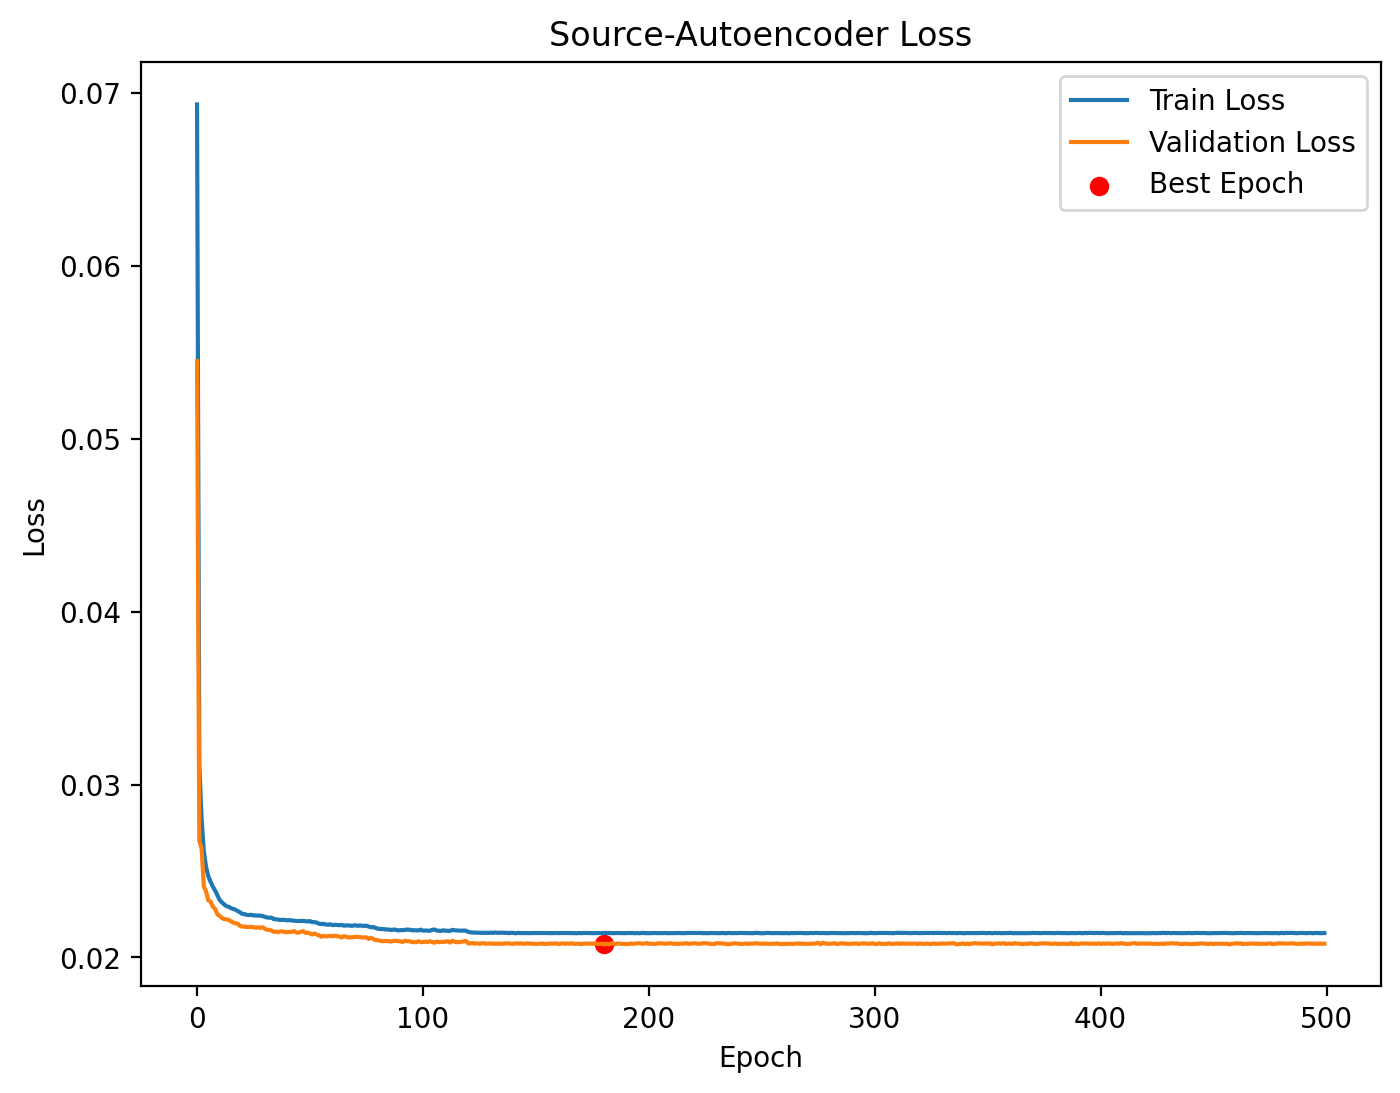

In [28]:
import umap
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # 设置图形大小

train_losses = [val for key, val in loss_report_en.items() if 'train' in key]
val_losses = [val for key, val in loss_report_en.items() if 'val' in key]
best_val_loss = val_losses[best_epoch]
epochs = range(len(train_losses))
%config InlineBackend.figure_format = 'retina'
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.scatter(best_epoch, best_val_loss, color='red', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Source-Autoencoder Loss')
plt.grid(False)
plt.legend()
plt.show()

In [84]:
source_umap = source_encoder.encode(Xsource_trainTensor).cpu().detach().numpy()
umap_model = umap.UMAP()
embedding = umap_model.fit_transform(source_umap)

bulk_array = np.array(['source'] * source_umap.shape[0])
#sc_array = np.array(['target'] * numpy_sc.shape[0])
label = bulk_array
color_mapping = {'source': '#4DBBD5', 'target': '#3C5488'}
label_color = [color_mapping[val] for val in label]

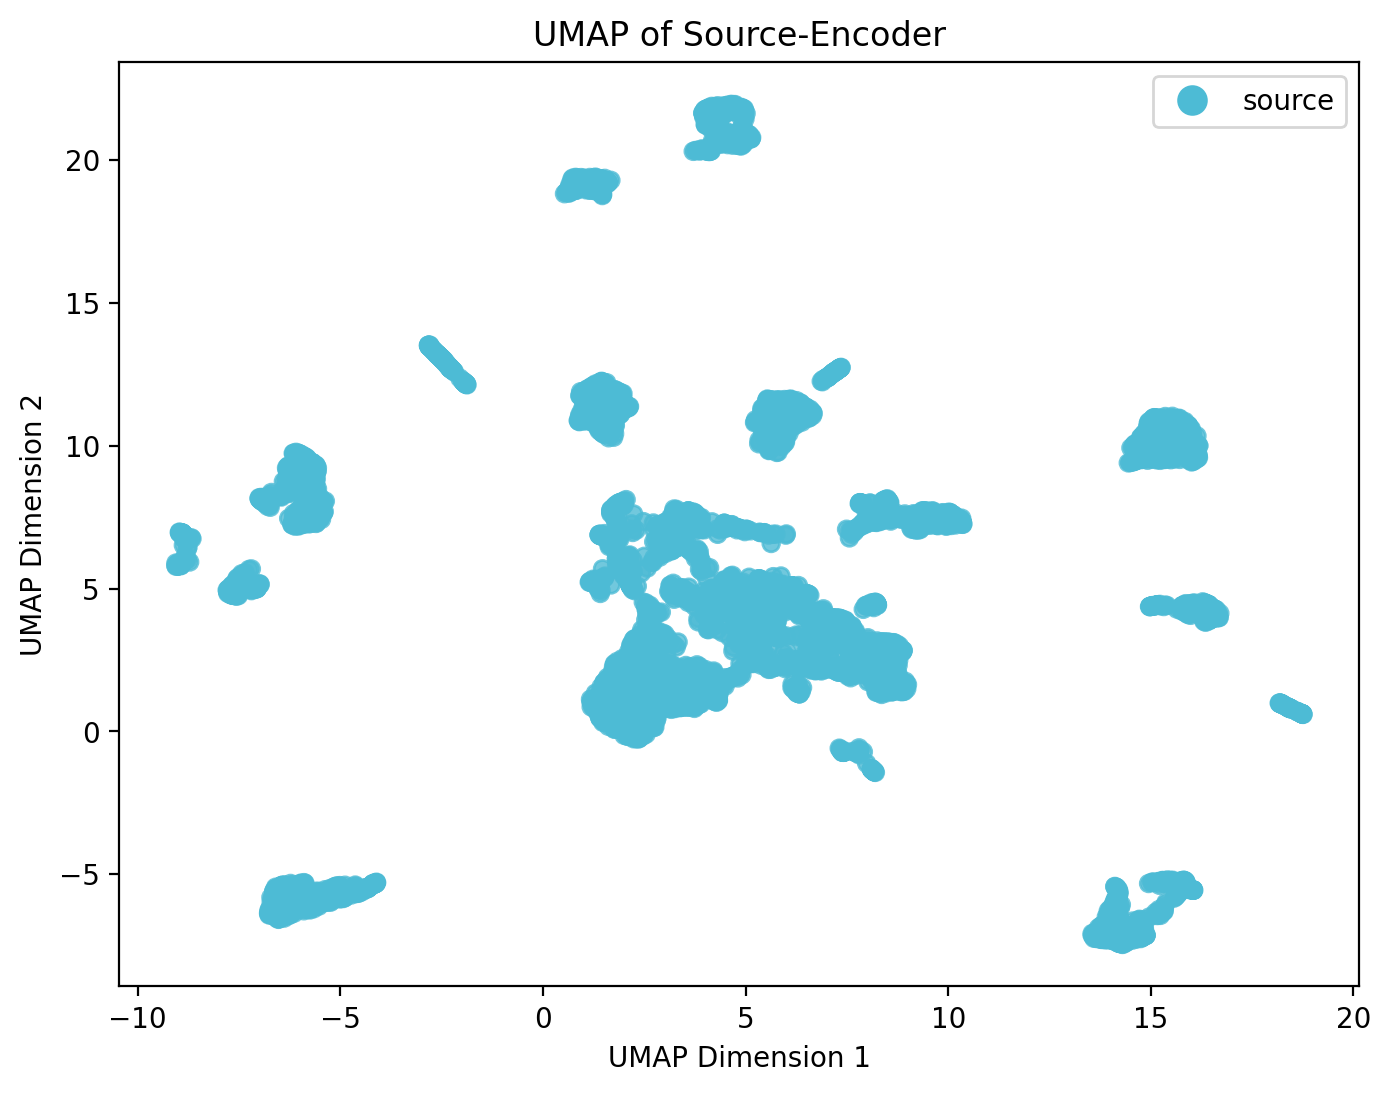

<Figure size 640x480 with 0 Axes>

In [85]:
plt.figure(figsize=(8, 6))  # 设置图形大小

plt.scatter(embedding[:, 0], embedding[:, 1], c=label_color, alpha=0.8)  # 调整透明度

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP of Source-Encoder')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='#4DBBD5', label='source', markersize=10, linestyle='')],loc='best')#plt.Line2D([0], [0], marker='o', color='#3C5488', label='target', markersize=10, linestyle='')], )

plt.grid(False)
#plt.gca().spines['top'].set_visible(False)  # 隐藏顶部边框
#plt.gca().spines['right'].set_visible(False)  # 隐藏右侧边框

#plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)  # 显示刻度线
#fig = plt.gcf()  # 获取当前图形对象
#fig.set_size_inches(5.5, 5.5)  # 设置图形尺寸为 7.5x7.5 inches
#fig.set_dpi(300)
plt.show()
plt.clf()  # 清除图形

In [87]:
embedding.shape

(6184, 2)

In [93]:
label_test.head()

,aliquot_barcode,cancer type,platform,patient_annotation,sample_annotation,aliquot_annotation,aliquot_annotation_updated,AWG_excluded_because_of_pathology,AWG_pathology_exclusion_reason,Reviewed_by_EPC,Do_not_use,sampleage,tcga_type,sample_type
TCGA-OR-A5J1-01A-11D-A29J-05,TCGA-OR-A5J1-01A-11D-A29J-05,ACC,HumanMethylation450,-100,-100,-100,-100.0,0.0,-100,1.0,False,58.0,1,1
TCGA-OR-A5J2-01A-11D-A29J-05,TCGA-OR-A5J2-01A-11D-A29J-05,ACC,HumanMethylation450,-100,-100,-100,-100.0,0.0,-100,1.0,False,44.0,1,1
TCGA-OR-A5J3-01A-11D-A29J-05,TCGA-OR-A5J3-01A-11D-A29J-05,ACC,HumanMethylation450,-100,-100,-100,-100.0,0.0,-100,1.0,False,23.0,1,1
TCGA-OR-A5J4-01A-11D-A29J-05,TCGA-OR-A5J4-01A-11D-A29J-05,ACC,HumanMethylation450,-100,-100,-100,-100.0,0.0,-100,1.0,False,23.0,1,1
TCGA-OR-A5J5-01A-11D-A29J-05,TCGA-OR-A5J5-01A-11D-A29J-05,ACC,HumanMethylation450,-100,-100,-100,-100.0,0.0,-100,1.0,False,30.0,1,1


In [95]:
labeltype = label_test.loc[:,'cancer type']
print(labeltype)
labeltype = np.array(labeltype)
print(labeltype)

TCGA-OR-A5J1-01A-11D-A29J-05     ACC
TCGA-OR-A5J2-01A-11D-A29J-05     ACC
TCGA-OR-A5J3-01A-11D-A29J-05     ACC
TCGA-OR-A5J4-01A-11D-A29J-05     ACC
TCGA-OR-A5J5-01A-11D-A29J-05     ACC
                                ... 
TCGA-ZH-A8Y5-01A-11D-A418-05    CHOL
TCGA-ZH-A8Y6-01A-11D-A418-05    CHOL
TCGA-ZH-A8Y8-01A-51D-A418-05    CHOL
TCGA-ZU-A8S4-01A-11D-A418-05    CHOL
TCGA-ZU-A8S4-11A-11D-A418-05    CHOL
Name: cancer type, Length: 9664, dtype: object
['ACC' 'ACC' 'ACC' ... 'CHOL' 'CHOL' 'CHOL']


In [97]:
Ysource_train_type, Ysource_test_type = train_test_split(labeltype, test_size=test_size, random_state=42)
Ysource_train_type, Ysource_valid_type = train_test_split(Ysource_train_type, test_size=valid_size, random_state=42)

In [98]:
result = np.column_stack((embedding,Ysource_train_type ,Ysource_train))
print(result[:3])
ump = pd.DataFrame(result)

# CSV文件路径
csv_file = 'data/resultump_typetcga.csv'

# 写入CSV文件
ump.to_csv(csv_file, index=False)

[[15.903753280639648 10.525477409362793 'BRCA' 1]
 [-5.648536682128906 8.402670860290527 'KIRP' 1]
 [5.748704433441162 3.795959234237671 'LUAD' 1]]


In [29]:
args.dropout = 0.3

In [30]:
    # Defined the model of predictor 
    if reduce_model == "AE":
        model = PretrainedPredictor(input_dim=data.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims, 
                                hidden_dims_predictor=preditor_hdims,output_dim=1,
                                pretrained_weights=bulk_encoder,freezed=bool(args.freeze_pretrain),drop_out=args.dropout,drop_out_predictor=args.dropout)
    if reduce_model == "DAE":
        model = PretrainedPredictor(input_dim=data.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims, 
                                hidden_dims_predictor=predict_hdims,output_dim=2,
                                pretrained_weights=bulk_encoder,freezed=bool(args.freeze_pretrain),drop_out=args.dropout,drop_out_predictor=args.dropout)                                
    elif reduce_model == "VAE":
        model = PretrainedVAEPredictor(input_dim=Xsource_train.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims, 
                        hidden_dims_predictor=preditor_hdims,output_dim=dim_model_out,
                        pretrained_weights=bulk_encoder,freezed=bool(args.freeze_pretrain),z_reparam=bool(args.VAErepram),drop_out=args.dropout,drop_out_predictor=args.dropout)
    #print("@@@@@@@@@@@")

In [31]:
    #    model.cuda()
    model.to(device)
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    #loss_function = nn.L1Loss()
    #loss_function = nn.SmoothL1Loss()
    #loss_function = nn.MSELoss()
    loss_function = nn.CrossEntropyLoss()
    exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

In [32]:
label

array([1, 1, 1, ..., 1, 1, 0])

In [33]:
model

PretrainedPredictor(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=395314, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (bottleneck): Linear(in_features=256, out_features=512, bias=True)
  (predictor): Predictor(
    (predictor): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.3, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): BatchNorm1d(128, ep

In [34]:
epochs = 300
args.checkpoint = "False"

In [35]:
#source_model_path = 'save/bulk_pre/integrate_data_scDNAm_drug_liner_bottle_512_edim_512,256_pdim_256,128,64_model_DAE_dropout_0.5_lr_0.01_mod_new_type_notcga'
source_model_path = 'save/bulk_pre/integrate_data_scDNAm_drug_liner_bottle_512_edim_512,256_pdim_256,128,64_model_DAE_dropout_0.3_lr_0.01_mod_new_type_overtcga_downsampling'

In [89]:
import importlib
import trainers as t

# 重新加载 trainers 模块
importlib.reload(t)

<module 'trainers' from '/home/fan_qi/fan_qi/DNAm/DNAm/trainers.py'>

In [36]:
    # Train prediction model if load is not false
    #print("1111")
    if(args.checkpoint != "False"):
        load = True
    else:
        load = False
    model,report,best_epoch = t.train_predictor_model(model,dataloaders_source,
                                            optimizer,loss_function,epochs,exp_lr_scheduler,load=load,save_path=source_model_path)

0.4191914325760257
0.3886106573045254
0.338743983737884
0.32782305777072906
0.3304773251856527
0.5581251978874207
0.32833740980394427
0.32488711923360825
0.32656505703926086
0.3228481747210026
0.32649328920149034
0.33193422108888626
0.32426885154939467
0.33044328540563583
0.32518294165211337
1.2214440256357193
0.3246524516613253
0.39061421900987625
0.32514094633440815
0.48329222574830055
0.3228978562739588
0.32378891110420227
0.3233303302718747
0.3505537435412407
0.3236513474295216
0.36250636354088783
0.32070435439386674
0.3258335702121258
0.32118189815552006
0.3207588866353035
0.32122592579933906
0.589169554412365
0.3227439397765744
0.333840474486351
0.3224597236802501
0.5942841023206711
0.32184103996522967
0.3266926258802414
0.32104576306958355
0.3227606564760208
0.3200248527911402
0.3225625939667225
0.31966568481537605
0.3271828070282936
0.321243473599034
0.32329027727246284
0.3200968071337669
0.32253535836935043
0.3204191019458155
0.37466493621468544
0.3189856083162369
0.3222254477

In [37]:
best_epoch

205

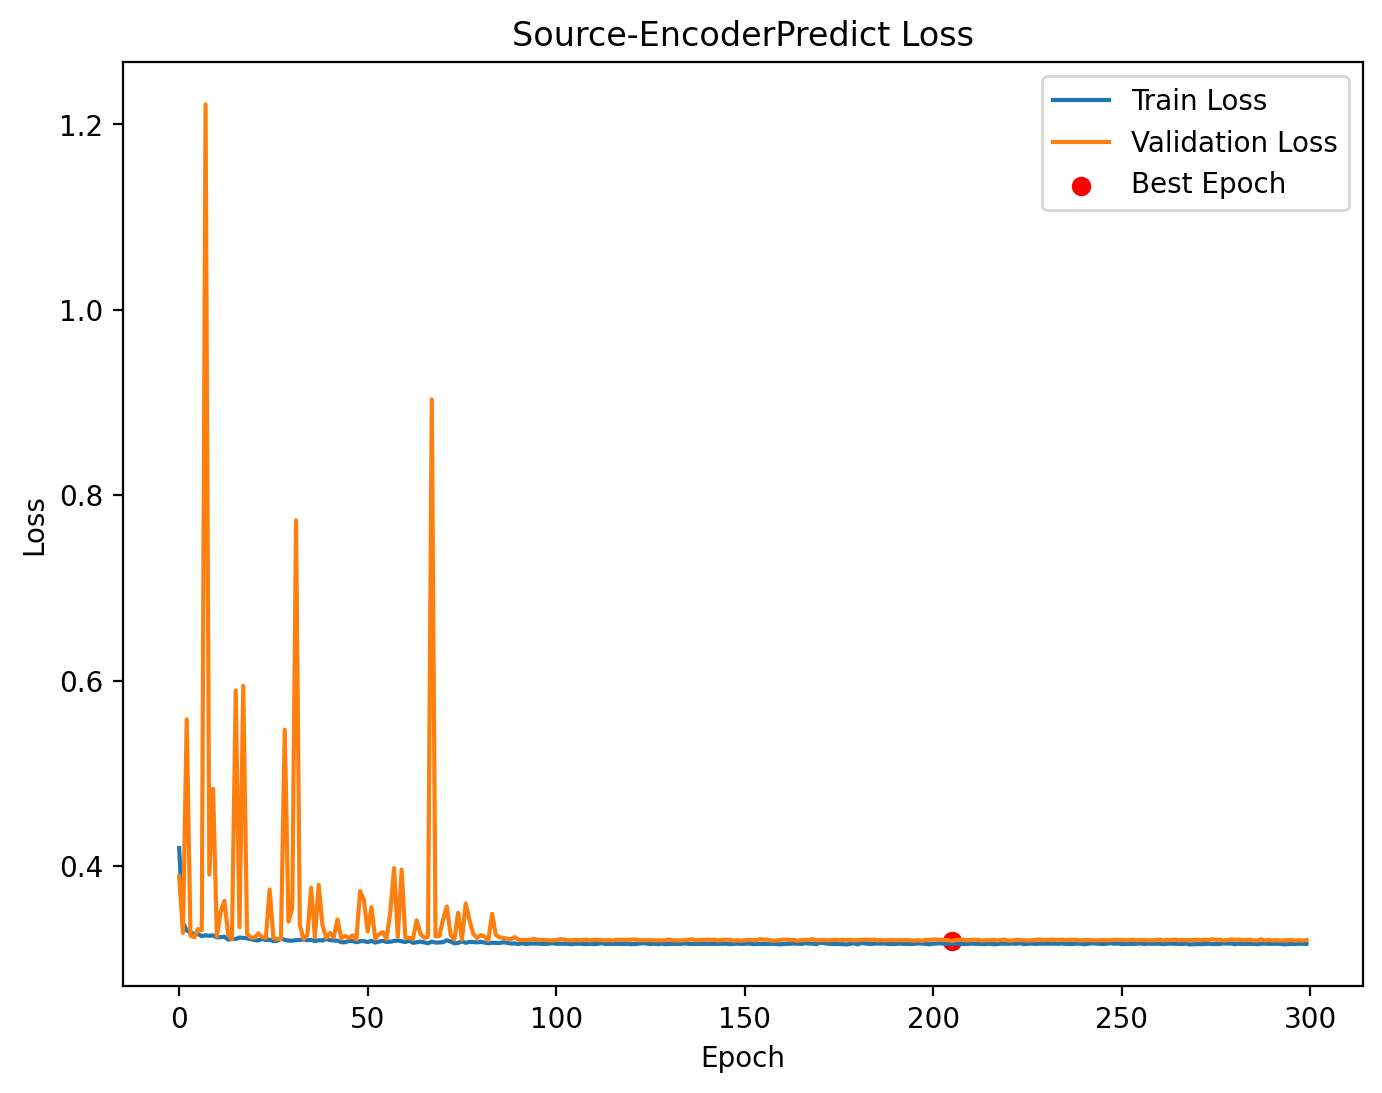

In [38]:
import umap
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # 设置图形大小


train_losses = [val for key, val in report.items() if 'train' in key]
val_losses = [val for key, val in report.items() if 'val' in key]
best_val_loss = val_losses[best_epoch]
epochs = range(len(train_losses))
%config InlineBackend.figure_format = 'retina'
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.scatter(best_epoch, best_val_loss, color='red', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Source-EncoderPredict Loss')
plt.grid(False)
plt.legend()
plt.show()

In [39]:
    data_target=pd.read_csv('data/last_overarray.csv',index_col=0)#source_data_path
    label_target=pd.read_csv('data/array_inf.csv',index_col=0)  
    data_target = data_target.fillna(0.5)
    data_target = np.transpose(data_target)
    # Filter out na values
    selected_idx = label_target.loc[:,'Tissue']!=na
    data_t = data_target.loc[selected_idx,:]
    # Extract labels
    label_t = label_target.loc[selected_idx,'Tissue']
    # Scaling data
    #mmscaler = preprocessing.MinMaxScaler()
    #data = mmscaler.fit_transform(data)
    label_t = label_t.values.reshape(-1,1)
    data_t = data_t.to_numpy()

In [40]:
print(label_target.head()) 
print(label_t[:4,:4])
data_t.shape

              Title                    Source name  Patientid Gender  Age  \
Accession                                                                   
GSM2714567  401504C  Patient 401504; Tissue mucosa     401504      M   86   
GSM2714568  401816C  Patient 401816; Tissue mucosa     401816      M   69   
GSM2714569  401728A   Patient 401728; Tissue tumor     401728      M   58   
GSM2714570  402272A   Patient 402272; Tissue tumor     402272      M   72   
GSM2714571  401728C  Patient 401728; Tissue mucosa     401728      M   58   

            Tissue      Disease state  
Accession                              
GSM2714567  mucosa  Colorectal cancer  
GSM2714568  mucosa  Colorectal cancer  
GSM2714569   tumor  Colorectal cancer  
GSM2714570   tumor  Colorectal cancer  
GSM2714571  mucosa  Colorectal cancer  
[['mucosa']
 ['mucosa']
 ['tumor']
 ['tumor']]


(261, 395249)

In [41]:
    le = LabelEncoder()
    label_t = le.fit_transform(label_t)
    label_t

/home/fan_qi/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

In [42]:
print(device)
batch_size = 50

cuda:2


In [43]:
    # Along with the leiden conditions for CVAE propose
    Xtarget_train, Xtarget_valid, Ctarget_train, Ctarget_valid = train_test_split(data_t,label_t, test_size=valid_size, random_state=42)
    # Construct datasets and data loaders
    Xtarget_trainTensor = torch.FloatTensor(Xtarget_train).to(device)
    Xtarget_validTensor = torch.FloatTensor(Xtarget_valid).to(device)
    #print(Xtarget_validTensor.shape)
    # Use leiden label if CVAE is applied 
    Ctarget_trainTensor = torch.LongTensor(Ctarget_train).to(device)
    Ctarget_validTensor = torch.LongTensor(Ctarget_valid).to(device)
    #print("C",Ctarget_validTensor )
    X_allTensor = torch.FloatTensor(data_t).to(device)
    C_allTensor = torch.LongTensor(label_t).to(device)
    
    train_dataset = TensorDataset(Xtarget_trainTensor, Ctarget_trainTensor)
    valid_dataset = TensorDataset(Xtarget_validTensor, Ctarget_validTensor)

    Xtarget_trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    Xtarget_validDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

    dataloaders_pretrain = {'train':Xtarget_trainDataLoader,'val':Xtarget_validDataLoader}
    print('START SECTION OF LOADING SC DATA TO THE TENSORS')

START SECTION OF LOADING SC DATA TO THE TENSORS


In [44]:
batch_size

50

In [45]:
    # Split source data
    Xsource_train_all, Xsource_test, Ysource_train_all, Ysource_test = train_test_split(data,label, test_size=test_size, random_state=42)
    Xsource_train, Xsource_valid, Ysource_train, Ysource_valid = train_test_split(Xsource_train_all,Ysource_train_all, test_size=valid_size, random_state=42)

    # Transform source data
    # Construct datasets and data loaders
    Xsource_trainTensor = torch.FloatTensor(Xsource_train).to(device)
    Xsource_validTensor = torch.FloatTensor(Xsource_valid).to(device)

    Ysource_trainTensor = torch.LongTensor(Ysource_train).to(device)
    Ysource_validTensor = torch.LongTensor(Ysource_valid).to(device)

    sourcetrain_dataset = TensorDataset(Xsource_trainTensor, Ysource_trainTensor)
    sourcevalid_dataset = TensorDataset(Xsource_validTensor, Ysource_validTensor)

    Xsource_trainDataLoader = DataLoader(dataset=sourcetrain_dataset, batch_size=batch_size, shuffle=True)
    Xsource_validDataLoader = DataLoader(dataset=sourcevalid_dataset, batch_size=batch_size, shuffle=True)

    dataloaders_source = {'train':Xsource_trainDataLoader,'val':Xsource_validDataLoader}
    #print('END SECTION OF LOADING BULK DATA')

In [46]:
#sc_encoder_path = 'save/sc_encoder/integrate_data_scDNAm_drug_liner_bottle_512_edim_512,256_pdim_256,128,64_model_DAE_dropout_0.5_lr_0.01_mod_new_type_notcga'
sc_encoder_path = 'save/sc_encoder/integrate_data_scDNAm_drug_liner_bottle_512_edim_512,256_pdim_256,128,64_model_DAE_dropout_0.5_lr_0.01_mod_new_type_overtcga_downsampling'

In [90]:
sc_encoder_path

'save/sc_encoder/integrate_data_scDNAm_drug_liner_bottle_512_edim_512,256_pdim_256,128,64_model_DAE_dropout_0.5_lr_0.01_mod_new_type_overtcga_downsampling'

In [91]:
    # Construct target encoder
    if reduce_model == "AE":
        encoder = AEBase(input_dim=data_target.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims,drop_out=args.dropout)
        loss_function_e = nn.MSELoss()
    elif reduce_model == "VAE":
        encoder = VAEBase(input_dim=data_target.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims,drop_out=args.dropout)
    if reduce_model == "DAE":
        encoder = AEBase(input_dim=data_target.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims,drop_out=0.3)
        loss_function_e = nn.MSELoss()        

    logging.info("Target encoder structure is: ")
    logging.info(encoder)
    
    encoder.to(device)
    optimizer_e = optim.Adam(encoder.parameters(), lr=1e-2)
    loss_function_e = nn.MSELoss()
    exp_lr_scheduler_e = lr_scheduler.ReduceLROnPlateau(optimizer_e)

In [110]:
args.checkpoint = 'True'

In [111]:
epochs = 300

In [112]:
    # Pretrain target encoder training
    # Pretain using autoencoder is pretrain is not False
    if(str(args.sc_encoder_path)!='False'):
        # Pretrained target encoder if there are not stored files in the harddisk
        train_flag = True
        sc_encoder_path = str(sc_encoder_path)
        print("Pretrain=="+sc_encoder_path)
        
        # If pretrain is not False load from check point
        if(args.checkpoint!="False"):
            # if checkpoint is not False, load the pretrained model
            try:
                encoder.load_state_dict(torch.load(sc_encoder_path,map_location=device))
                logging.info("Load pretrained target encoder from "+sc_encoder_path)
                train_flag = False

            except:
                logging.info("Loading failed, procceed to re-train model")
                train_flag = True

        # If pretrain is not False and checkpoint is False, retrain the model
        if train_flag == True:

            if reduce_model == "AE":
                encoder,loss_report_en = t.train_AE_model(net=encoder,data_loaders=dataloaders_pretrain,
                                            optimizer=optimizer_e,loss_function=loss_function_e,load=False,
                                            n_epochs=epochs,scheduler=exp_lr_scheduler_e,save_path=sc_encoder_path)
            if reduce_model == "DAE":
                encoder,loss_report_en,best_epoch_sc = t.train_DAE_model(net=encoder,data_loaders=dataloaders_pretrain,
                                            optimizer=optimizer_e,loss_function=loss_function_e,load=False,
                                            n_epochs=epochs,scheduler=exp_lr_scheduler_e,save_path=sc_encoder_path)
                                            
            elif reduce_model == "VAE":
                encoder,loss_report_en = t.train_VAE_model(net=encoder,data_loaders=dataloaders_pretrain,
                                optimizer=optimizer_e,load=False,
                                n_epochs=epochs,scheduler=exp_lr_scheduler_e,save_path=sc_encoder_path)
            #print(loss_report_en)
            logging.info("Pretrained finished")

Pretrain==save/sc_encoder/integrate_data_scDNAm_drug_liner_bottle_512_edim_512,256_pdim_256,128,64_model_DAE_dropout_0.5_lr_0.01_mod_new_type_overtcga_downsampling


In [113]:
best_epoch_sc

278

In [114]:
encoder

AEBase(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=395249, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (bottleneck): Linear(in_features=256, out_features=512, bias=True)
  (decoder_input): Linear(in_features=512, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=512, out_features=395249, bias=True)
    (1): Sigmoid()
  )
)

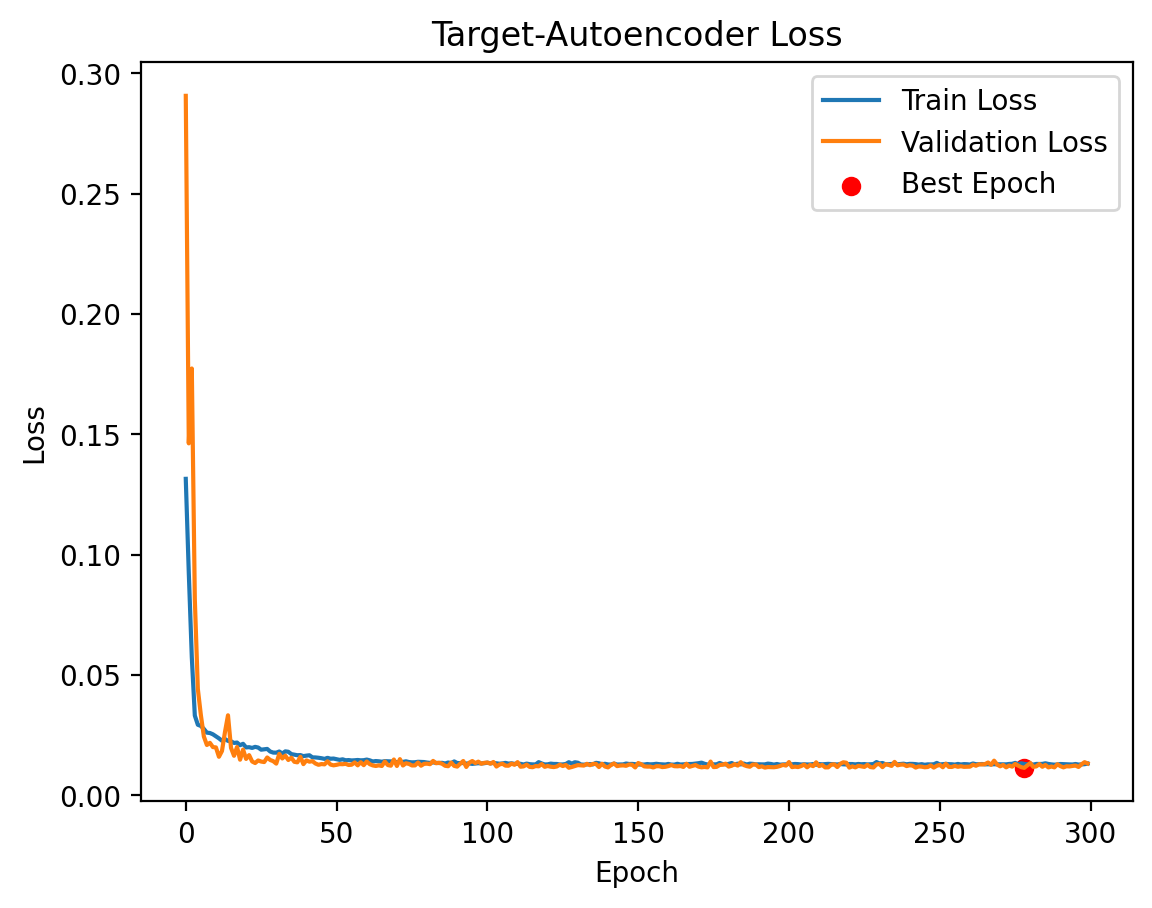

In [63]:
import umap
import matplotlib.pyplot as plt
train_losses = [val for key, val in loss_report_en.items() if 'train' in key]
val_losses = [val for key, val in loss_report_en.items() if 'val' in key]
best_val_loss = val_losses[best_epoch_sc]
epochs = range(len(train_losses))
%config InlineBackend.figure_format = 'retina'
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.scatter(best_epoch_sc, best_val_loss, color='red', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Target-Autoencoder Loss')
plt.grid(False)
plt.legend()
plt.show()

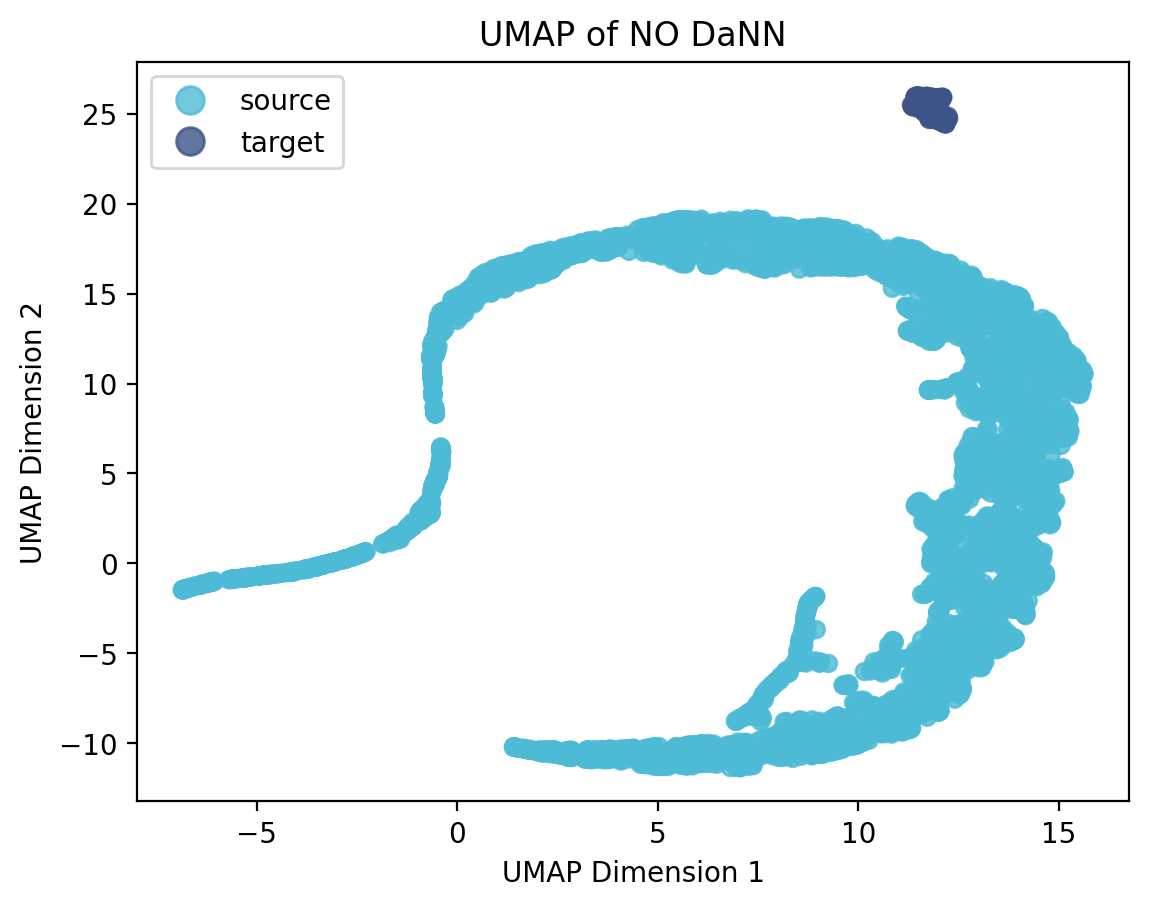

<Figure size 640x480 with 0 Axes>

In [53]:
Dann_bulk = model.encode(Xsource_trainTensor)
Dann_bulk.shape
Dann_sc = encoder.encode(Xtarget_trainTensor)
Dann_sc.shape
numpy_bulk = Dann_bulk.cpu().detach().numpy()
numpy_sc = Dann_sc.cpu().detach().numpy()
concatenated_array_before = np.concatenate((numpy_bulk, numpy_sc), axis=0)
# 使用UMAP进行降维
umap_model = umap.UMAP()
embedding = umap_model.fit_transform(concatenated_array_before)
# 创建包含label字符串的数组
bulk_array = np.array(['source'] * numpy_bulk.shape[0])
sc_array = np.array(['target'] * numpy_sc.shape[0])
# 将两个数组按行拼接在一起
label = np.concatenate((bulk_array, sc_array), axis=0)
#label = np.where(label == 'bulk', "#FFA07A", '#9370DB')
# 根据类别值映射不同的颜色
color_mapping = {'source': '#4DBBD5CC', 'target': '#3C5488CC'}
label_color = [color_mapping[val] for val in label]

# 绘制UMAP图
plt.scatter(embedding[:, 0], embedding[:, 1], c=label_color, label='Label')  # 添加图例标签
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP of NO DaNN')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='#4DBBD5CC', label='source', markersize=10, linestyle=''),
                    plt.Line2D([0], [0], marker='o', color='#3C5488CC', label='target', markersize=10, linestyle='')])
plt.grid(False)
# 设置图形边框为黑色
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')

# 显示刻度线
#plt.tick_params(axis='both', which='both', direction='in')
plt.show()
plt.clf()  # 清除图形

In [54]:
concatenated_array_type = np.concatenate((Ysource_train, Ctarget_train), axis=0)
concatenated_array_type[:5]

array([1, 1, 1, 1, 1])

In [55]:
result = np.column_stack((embedding,label ,concatenated_array_type))
print(result[:3])
ump = pd.DataFrame(result)

# CSV文件路径
csv_file = 'data/resultump_typetcga_noDann.csv'

# 写入CSV文件
ump.to_csv(csv_file, index=False)

[['8.650607' '-9.970302' 'source' '1']
 ['4.7741795' '17.448881' 'source' '1']
 ['14.06664' '6.3615026' 'source' '1']]


In [115]:
mod = 'ori'
epochs = 300

#target_model_path = 'save/sc_pre/integrate_data_scDNAm_drug_liner_bottle_512_edim_512,256_pdim_256,128,64_model_DAE_dropout_0.5_lr_0.01_mod_new_type_notcga'
target_model_path = 'save/sc_pre/integrate_data_scDNAm_drug_liner_bottle_512_edim_512,256_pdim_256,128,64_model_DAE_dropout_0.5_lr_0.01_mod_new_type_overtcga_downsampling'

In [116]:
args.checkpoint = 'False'

In [117]:
device

device(type='cuda', index=2)

In [118]:
args.mmd_weight

0.25

In [119]:
    # Using DaNN transfer learning
    # DaNN model
    # Set predictor loss
    loss_d = nn.CrossEntropyLoss()
    optimizer_d = optim.Adam(encoder.parameters(), lr=1e-2)
    exp_lr_scheduler_d = lr_scheduler.ReduceLROnPlateau(optimizer_d)
       
    # Set DaNN model
    #DaNN_model = DaNN(source_model=source_encoder,target_model=encoder)
    DaNN_model = DaNN(source_model=model,target_model=encoder,fix_source=bool(args.fix_source))
    DaNN_model.to(device)

    # Set distribution loss 
    def loss(x,y,GAMMA=args.mmd_GAMMA):
        result = mmd.mmd_loss(x,y,GAMMA)
        return result

    loss_disrtibution = loss
     
    # Train DaNN model
    logging.info("Trainig using" + mod + "model")
    #target_model = TargetModel(source_model,encoder)
    # Switch to use regularized DaNN model or not
    if mod == 'ori':
        if args.checkpoint == 'True':
            DaNN_model, report_ = t.train_DaNN_model(DaNN_model,
                                dataloaders_source,dataloaders_pretrain,
                                # Should here be all optimizer d?
                                optimizer_d, loss_d,
                                epochs,exp_lr_scheduler_d,
                                dist_loss=loss_disrtibution,
                                load=target_model_path+"_DaNN.pkl",
                                weight = args.mmd_weight,
                                save_path=target_model_path+"_DaNN.pkl")
        else:
            DaNN_model, report_,best_epoch_dann = t.train_DaNN_model(DaNN_model,
                                dataloaders_source,dataloaders_pretrain,
                                # Should here be all optimizer d?
                                optimizer_d, loss_d,
                                epochs,exp_lr_scheduler_d,
                                dist_loss=loss_disrtibution,
                                load=False,
                                weight = args.mmd_weight,
                                save_path=target_model_path+"_DaNN.pkl")
    # Train DaNN model with new loss function                    
    if mod == 'new': 
        #args.checkpoint = 'False'
        if args.checkpoint == 'True':
            DaNN_model, report_ = t.train_DaNN_model(DaNN_model,
                            dataloaders_source,dataloaders_pretrain,
                            # Should here be all optimizer d?
                            optimizer_d, loss_d,
                            epochs,exp_lr_scheduler_d,
                            dist_loss=loss_disrtibution,
                            load=selected_model,
                            weight = args.mmd_weight,
                            save_path=target_model_path+"_DaNN.pkl")
        else:
            DaNN_model, report_, _, _ = t.train_DaNN_model(DaNN_model,
                                dataloaders_source,dataloaders_pretrain,
                                # Should here be all optimizer d?
                                optimizer_d, loss_d,
                                epochs,exp_lr_scheduler_d,
                                dist_loss=loss_disrtibution,
                                load=False,
                                weight = args.mmd_weight,
                                save_path=target_model_path+"_DaNN.pkl",
                                device=device)                        

    encoder = DaNN_model.target_model
    source_model = DaNN_model.source_model
    logging.info("Transfer DaNN finished")

In [120]:
best_epoch_dann

88

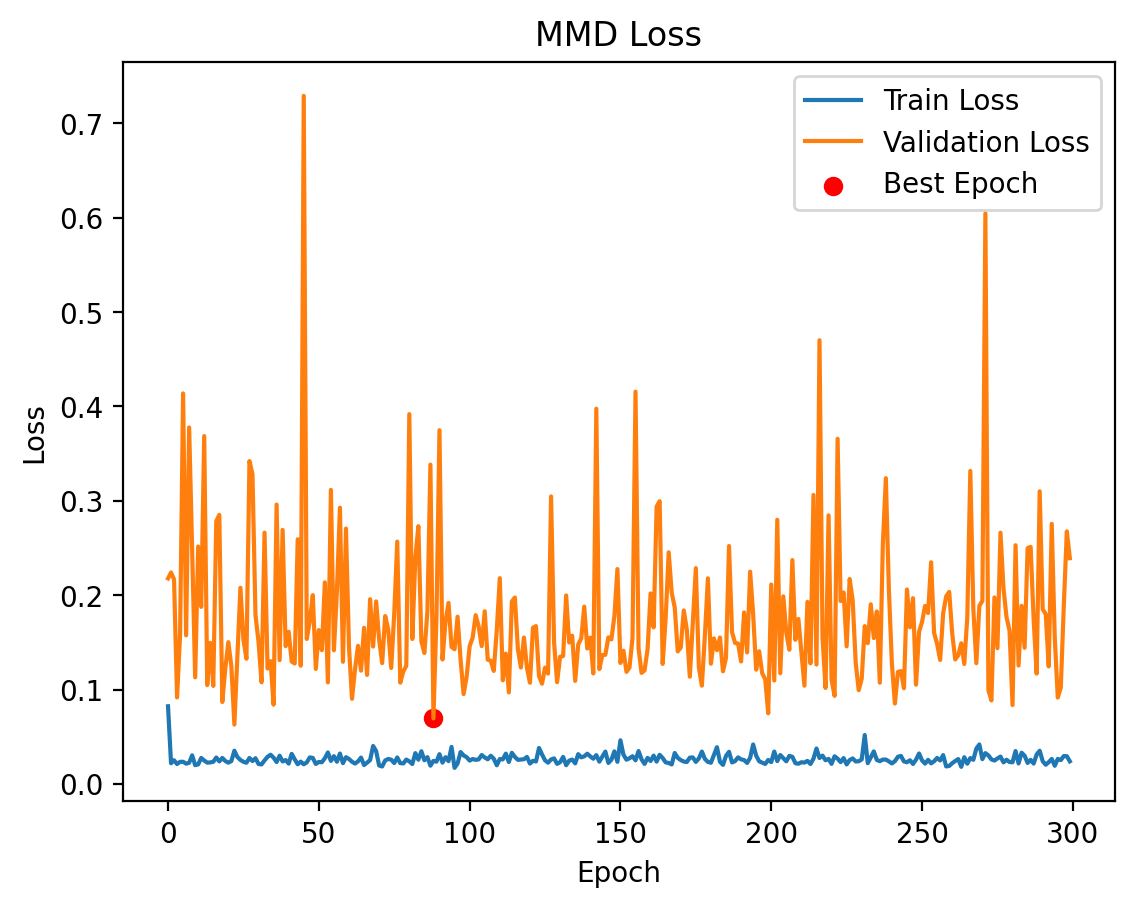

In [121]:
# 提取训练和验证损失值
train_losses = [val for key, val in report_[1].items() if 'train' in key]
val_losses = [val for key, val in report_[1].items() if 'val' in key]
epoch = range(len(train_losses))
best_val_loss = val_losses[best_epoch_dann]
plt.plot(epoch, train_losses, label='Train Loss')
plt.plot(epoch, val_losses, label='Validation Loss')
plt.scatter(best_epoch_dann, best_val_loss, color='red', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MMD Loss')
plt.grid(False)
plt.legend()
plt.show()

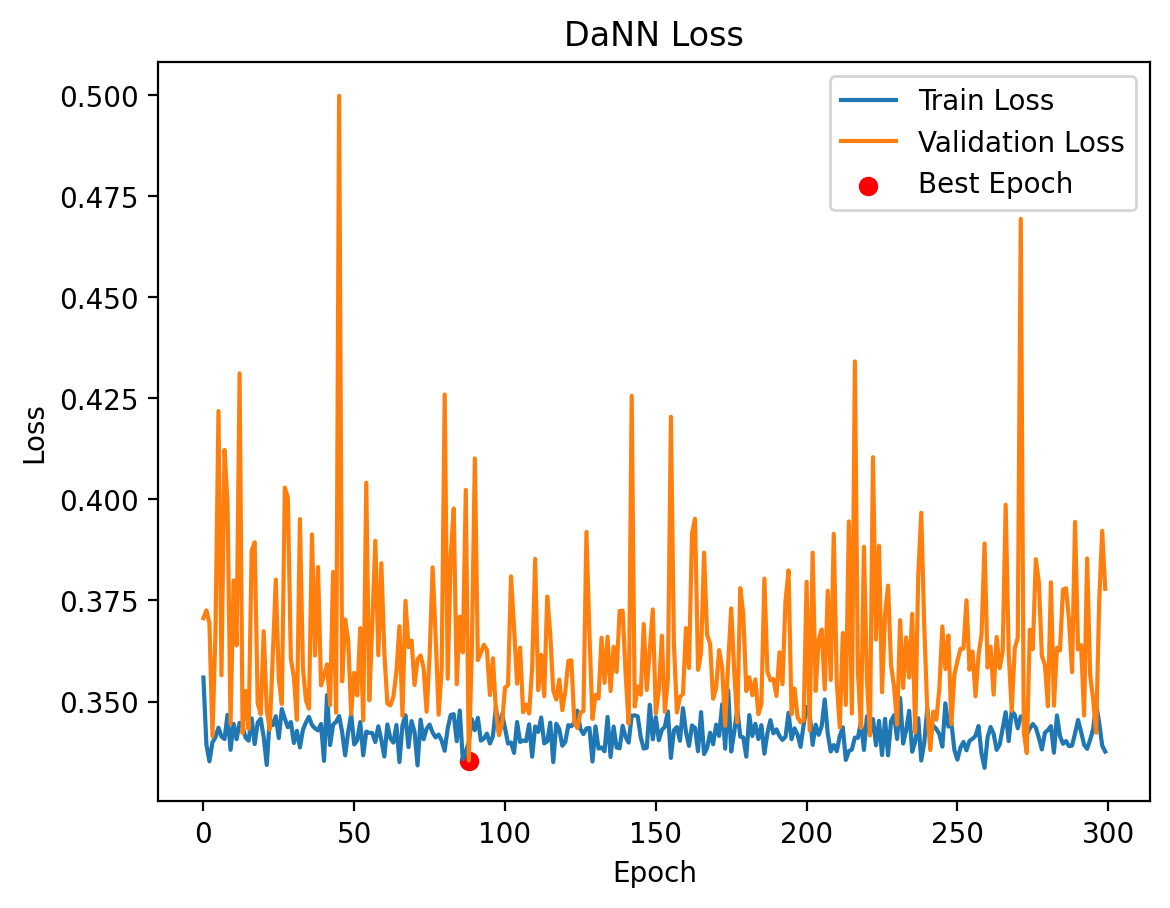

In [122]:
# 提取训练和验证损失值
train_losses = [val for key, val in report_[0].items() if 'train' in key]
val_losses = [val for key, val in report_[0].items() if 'val' in key]
epoch = range(len(train_losses))
best_val_loss = val_losses[best_epoch_dann]

plt.plot(epoch, train_losses, label='Train Loss')
plt.plot(epoch, val_losses, label='Validation Loss')
plt.scatter(best_epoch_dann, best_val_loss, color='red', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DaNN Loss')
plt.grid(False)
plt.legend()
plt.show()

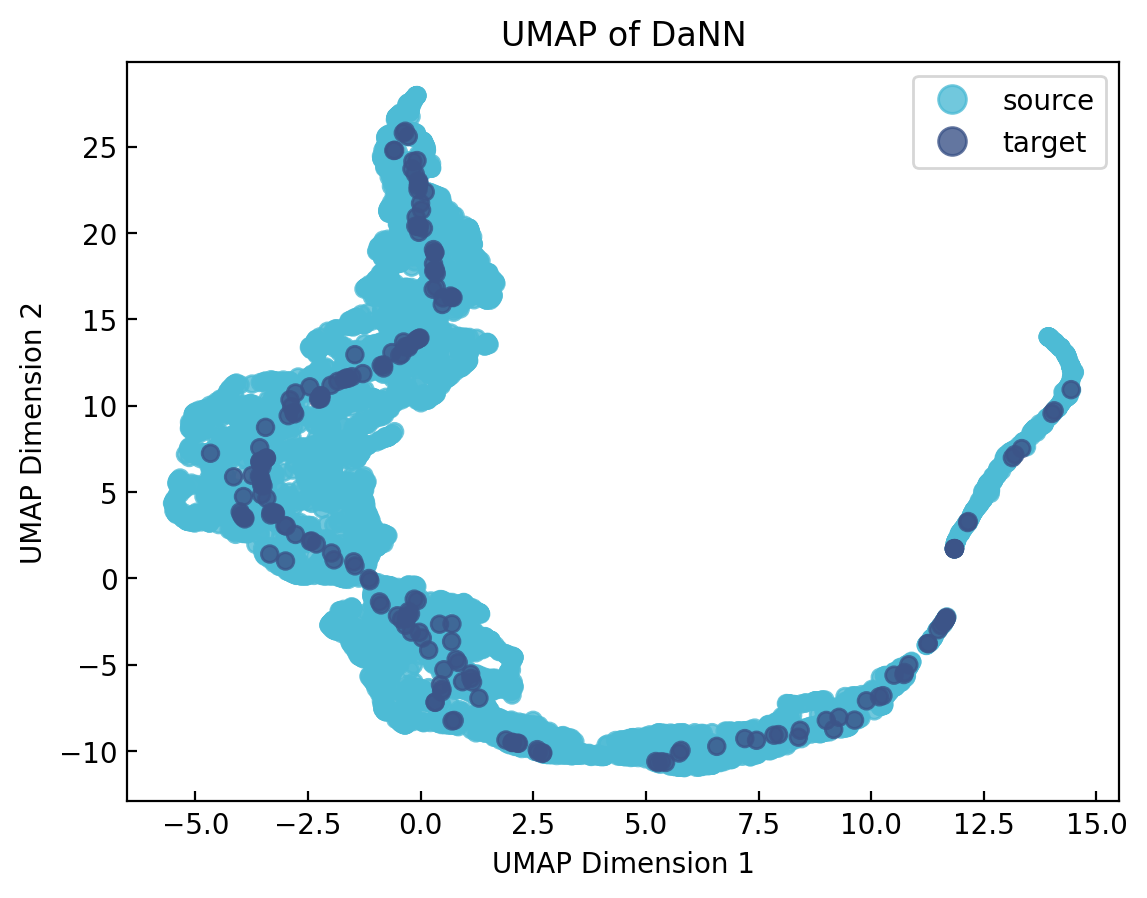

<Figure size 640x480 with 0 Axes>

In [123]:
Dann_bulk = source_model.encode(Xsource_trainTensor)
Dann_bulk.shape
Dann_sc = encoder.encode(Xtarget_trainTensor)
Dann_sc.shape
numpy_bulk = Dann_bulk.cpu().detach().numpy()
numpy_sc = Dann_sc.cpu().detach().numpy()
concatenated_array_before = np.concatenate((numpy_bulk, numpy_sc), axis=0)
# 使用UMAP进行降维
umap_model = umap.UMAP()
embedding = umap_model.fit_transform(concatenated_array_before)
# 创建包含label字符串的数组
bulk_array = np.array(['source'] * numpy_bulk.shape[0])
sc_array = np.array(['target'] * numpy_sc.shape[0])
# 将两个数组按行拼接在一起
label = np.concatenate((bulk_array, sc_array), axis=0)
#label = np.where(label == 'bulk', "#FFA07A", '#9370DB')
# 根据类别值映射不同的颜色
color_mapping = {'source': '#4DBBD5CC', 'target': '#3C5488CC'}
label_color = [color_mapping[val] for val in label]

# 绘制UMAP图
plt.scatter(embedding[:, 0], embedding[:, 1], c=label_color, label='Label')  # 添加图例标签
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP of DaNN')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='#4DBBD5CC', label='source', markersize=10, linestyle=''),
                    plt.Line2D([0], [0], marker='o', color='#3C5488CC', label='target', markersize=10, linestyle='')])
plt.grid(False)
# 设置图形边框为黑色
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')

# 显示刻度线
plt.tick_params(axis='both', which='both', direction='in')
plt.show()
plt.clf()  # 清除图形

In [134]:
concatenated_label = np.concatenate((Ysource_trainTensor.cpu().detach().numpy(), Ctarget_train), axis=0)
len(concatenated_label)

6392

In [140]:
result = np.column_stack((embedding, label ,concatenated_label))
print(result[:3])
ump = pd.DataFrame(result)


[['0.80838394' '-6.210231' 'source' '1']
 ['5.7327127' '-8.940117' 'source' '1']
 ['-2.6360614' '6.3565974' 'source' '1']]


In [141]:
# CSV文件路径
csv_file = 'data/resultump_DaNNtcgatype_downsample.csv'

# 写入CSV文件
ump.to_csv(csv_file, index=False)

In [124]:
    # Extract feature embeddings 
    # Extract prediction probabilities
    embedding_tensors = encoder.encode(X_allTensor)
    prediction_tensors = source_model.predictor(embedding_tensors)
    embeddings = embedding_tensors.detach().cpu().numpy()
    predictions = prediction_tensors.detach().cpu().numpy()
    print("predictions",predictions.shape)
    # Transform predict8ion probabilities to 0-1 labels

predictions (261, 2)


In [125]:
Y_test = C_allTensor.detach().cpu().numpy()
Y_test

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

In [126]:
    from sklearn.metrics import (average_precision_score,
                             classification_report, mean_squared_error, r2_score, roc_auc_score)

In [127]:
    # Save adata
################################################# END SECTION OF ANALYSIS FOR scRNA-Seq DATA #################################################
    report_df = {}
    
    sens_pb_results = predictions.argmax(axis=1)
    #lb_results = result
    
    #Y_test ture label
    ap_score = average_precision_score(Y_test, sens_pb_results)
    
    report_dict = classification_report(Y_test, np.argmax(predictions,axis=1), output_dict=True)
    f1score = report_dict['weighted avg']['f1-score']
    report_df['f1_score'] = f1score


In [128]:
np.argmax(predictions,axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [129]:
pd.DataFrame(report_dict).T 

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,149.000000
1,0.391837,0.857143,0.537815,112.000000
accuracy,0.367816,0.367816,0.367816,0.367816
macro avg,0.195918,0.428571,0.268908,261.000000
weighted avg,0.168144,0.367816,0.230787,261.000000


In [130]:
dl_result_train = source_model(Xsource_validTensor).detach().cpu().numpy()
lb_results_train = np.argmax(dl_result_train,axis=1)
pb_results_train = dl_result_train[:,1]

report_dict_train = classification_report(Ysource_valid, lb_results_train, output_dict=True)
report_df_train = pd.DataFrame(report_dict_train).T
report_df_train

,precision,recall,f1-score,support
0,0.957627,0.957627,0.957627,118.000000
1,0.996501,0.996501,0.996501,1429.000000
accuracy,0.993536,0.993536,0.993536,0.993536
macro avg,0.977064,0.977064,0.977064,1547.000000
weighted avg,0.993536,0.993536,0.993536,1547.000000


In [63]:
X_testTensor = torch.FloatTensor(Xsource_test).to(device)
dl_result_train = source_model(X_testTensor).detach().cpu().numpy()
lb_results_train = np.argmax(dl_result_train,axis=1)
pb_results_train = dl_result_train[:,1]

report_dict_train = classification_report(Ysource_test, lb_results_train, output_dict=True)
report_df_train = pd.DataFrame(report_dict_train).T
report_df_train

,precision,recall,f1-score,support
0,0.957983,0.904762,0.930612,126.000000
1,0.993385,0.997233,0.995305,1807.000000
accuracy,0.991205,0.991205,0.991205,0.991205
macro avg,0.975684,0.950997,0.962959,1933.000000
weighted avg,0.991077,0.991205,0.991088,1933.000000


In [67]:
X_testTensor = torch.FloatTensor(Xsource_test).to(device)
dl_result_train = source_model(X_testTensor).detach().cpu().numpy()
lb_results_train = np.argmax(dl_result_train,axis=1)
pb_results_train = dl_result_train[:,1]

report_dict_train = classification_report(Ysource_test, lb_results_train, output_dict=True)
report_df_train = pd.DataFrame(report_dict_train).T
report_df_train

,precision,recall,f1-score,support
0,0.907692,0.936508,0.921875,126.000000
1,0.995563,0.993359,0.994460,1807.000000
accuracy,0.989653,0.989653,0.989653,0.989653
macro avg,0.951628,0.964934,0.958167,1933.000000
weighted avg,0.989835,0.989653,0.989728,1933.000000
